<a href="https://colab.research.google.com/github/siddrrsh/StartOnAI/blob/master/RL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reinforcement Learning Tutorial in Python**
###### Created by **Xiaocong Yan** for [StartOnAI](https://startonai.com/)
---


## 1. Introduction to RL

![](https://lilianweng.github.io/lil-log/assets/images/RL_illustration.png)

image source: [A (Long) Peek into Reinforcement Learning by Lilian Weng](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html)

- What is Reinforcement Learning?
  - RL is a subfield in machine learning, it particularly focuses on training AI agents to behave optimally in a certain way by learning directly from its surrounding environment
  - As ML engineers, we have to provide algorithms and environment to train the agent with. More crucially, we have to engineer a reward system that will award the agent for choosing desirable actions while punish the agent for doing undesirable actions

- RL Applications
  - autonomous driving
  <img src="https://i.imgur.com/iT97tLQ.jpg?1" width="500" height="300">

  - advertisement selections
  - gameplaying AIs
    - AlphaGo mastering Go
    <img src="https://cdn.geekwire.com/wp-content/uploads/2016/03/160312-go-630x353.jpg" width="500" height="300">
    
    - AlphaStar strategizing in Starcraft II
    <img src="https://www.version2.dk/sites/v2/files/topillustration/2019/01/alphastarscreenshot.png" width="600" height="337">

  - agent in simulation learning to walk
  <img src="https://nav74neet.github.io/media/blog/walking.png" alt="alt text"  width='600' height='250'>

  - robots learning to grasp and manipulate objects
  <img src="https://i.ytimg.com/vi/iaF43Ze1oeI/maxresdefault.jpg" alt="alt text"  width='640' height='360'>

## 2. Explore-Exploit and Multi-Armed Bandit Problem

- A fundamental intuition of RL lies within the balancing of explore and exploit
- Example: casino multi-armed bandits (slot machines)
<img src="https://miro.medium.com/max/1250/1*7axVBpiVF4VQCxxP1UNcnw.png" alt="alt text"  width='743' height='280'>

  image source: [The Multi-Armed Bandit — to explore or exploit?](https://medium.com/10x-curiosity/the-multi-armed-bandit-to-explore-or-exploit-88556cb67c1c)

  - suppose we have three bandits with their own unique probablities of winning the jackpot
    - in this case, the agent is learning from the environment "casino" containing the three bandits by repeatedly taking action and playing, along the way figuring out which bandit is the best to play
      - at start, the agent has no ideas what the probabilities of the real win rate are
      - the agent then "explores" by playing and collecting sample proportions of win rate as estimates for the actual win rate
    - however, we know that sample proportions are not always accurate, especially at first when we haven't played the bandits enough yet
      - therefore, what we are actually seeking to solve is to make the agent find the bandit with the highest actual win rate as quickly as possible such that the agent can then "exploit" it by playing solely on it

### 2A. Greedy Algorithm
  - drawing upon an updating sample proportion ${\hat{p}}$ of each bandit (current number of wins / times played on the bandit), a basic greedy algorithm, as its name suggests, will only choose the bandit with the highest current sample proportion
  - problem: ${\hat{p}}$ may be drastically different than the real probability ${p}$, as we discussed, especially in the beginning where we don't have many samples or times played yet
    - in fact, in the beginning if we draw two bandits and one return a win and the other a loss, updating ${\hat{p}}$ will result in a 1.0 for the victorious bandit and a 0.0 for the losing bandit, meaning that we estimate the first bandit will always win and the second bandit will always lose.
      - we know this is probably not true
      - however, by the nature of the greedy algorithm, we will never again choose the losing bandit since no matter how many times we update the probability for the victorious bandit, it will never reach below 0 because of its initial one win, so we will always choose the first bandit instead
      - practically, we will be missing out on exploring the losing bandit at all and choose to solely exploit the winning bandit, when, in reality, the unlucky losing bandit may have a much higher real win rate

### 2B. Epsilon Greedy Algorithm
**I. Intuition**
  - solution to the greedy problem: adding a chance in each draw, parameterized by variable ${epsilon}$, where we will choose randomly from all the existing bandits, regardless of their sample proportions
  - thus it is created a fundamental algorithm behind RL

**II. Code**

optimal bandit: 4
bandit1 estimate win-rate: 0.0 | true win_rate: 0
bandit2 estimate win-rate: 0.229 | true win_rate: 0.25
bandit3 estimate win-rate: 0.537 | true win_rate: 0.5
bandit4 estimate win-rate: 0.748 | true win_rate: 0.75

total reward: 7097.0
overall win-rate: 0.7097
explore count: 1006
exploit count: 8994
optimal selection rate: 0.9237
num times selected each bandit: [276, 245, 242, 9237]


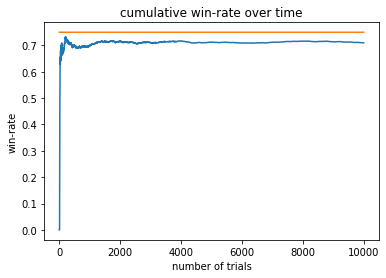

optimal bandit: 4
bandit1 estimate win-rate: 0.0 | true win_rate: 0
bandit2 estimate win-rate: 0.26 | true win_rate: 0.25
bandit3 estimate win-rate: 0.511 | true win_rate: 0.5
bandit4 estimate win-rate: 0.751 | true win_rate: 0.75

total reward: 71384.0
overall win-rate: 0.71384
explore count: 9965
exploit count: 90035
optimal selection rate: 0.92441
num times selected each bandit: [2486, 2524, 2549, 92441]


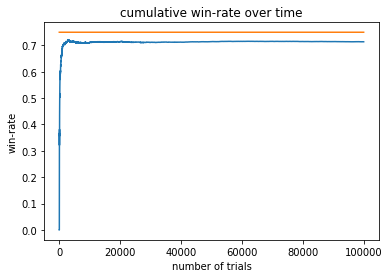

In [ ]:
# importing essential libraries for graphing and array processing
import matplotlib.pyplot as plt
import numpy as np

# creating the blueprint for a bandit slot machine
class Bandit:
  def __init__(self, p):
    self.p = p # the winning rate
    self.p_hat = 0 # sample proportion, or the estimation for the winning rate, intialized to 0
    self.n = 0 # number of samples collected on this bandit

  # pull the virtual bandit with a random probability p and check if won according to the winning rate
  def pull(self):
    # return 1 if won, 0 if lost
    return np.random.random() < self.p

  def update(self, x):
    # increment numbers of samples collected
    self.n += 1
    # calculate the new p hat from the previous p hat and the newly obtained value (0 or 1)
    self.p_hat = ((self.n - 1) * self.p_hat + x) / self.n

# run a simulation of multi-armed bandit problem using epsilon greedy
def run_simulation(bandits_probs_list, epsilon, N):
  """
  args
    bandits_probs_list: a list containing the win-rates of bandits that we want to create
    epsilon: greedy exploration rate
    n: numbers of trials, times we pull the bandits
  """
  # create a list of bandit objects according to their probabilities of win rate
  bandits = [Bandit(p) for p in bandits_probs_list]
  # initialize variables
  rewards = np.zeros(N)
  times_explored = 0
  times_exploited = 0
  times_optimal_chosen = 0
  # selecting the optimal bandit based the highest true probability
  optimal_bandit = np.argmax([bandit.p for bandit in bandits])
  # print out the true optimal bandit number
  print('optimal bandit:', optimal_bandit + 1) # +1 because optimal_bandit is 0 indexed

  # use epsilon_greedy to select the next bandit
  for i in range(N):
    # if probability drawn is smaller than epsilon, randomly select a bandit
    if np.random.random() < epsilon:
      times_explored += 1
      bandit = np.random.randint(len(bandits))
    # else selecting the bandit with the highest p_hat, the sample proportion
    else:
      times_exploited += 1
      bandit = np.argmax([bandit.p_hat for bandit in bandits])                
    # check if the bandit chosen is actually the optimal bandit
    if bandit == optimal_bandit:
      # update the correct action count
      times_optimal_chosen += 1
    # pull the arm for the bandit selected
    x = bandits[bandit].pull()
    # update rewards logs and sample proportion estimates accordingly
    rewards[i] = x
    bandits[bandit].update(x)     
  
  # print proportion estimates for each bandit
  for i, bandit in enumerate(bandits):
    print(f'bandit{i + 1} estimate win-rate: {round(bandit.p_hat, 3)} | true win_rate: {bandit.p}')

  # print total reward
  print()
  print('total reward:', rewards.sum())
  print('overall win-rate:', rewards.sum() / N)
  print('explore count:', times_explored)
  print('exploit count:', times_exploited)
  print('optimal selection rate:', times_optimal_chosen / N)
  print("num times selected each bandit:", [bandit.n for bandit in bandits])

  # plot the results
  cumulative_rewards = np.cumsum(rewards)
  win_rates = cumulative_rewards / (np.arange(N) + 1)
  plt.plot(win_rates)
  plt.plot(np.ones(N) * np.max(bandits_probs_list))
  plt.title('cumulative win-rate over time')
  plt.xlabel('number of trials')
  plt.ylabel('win-rate')
  plt.show()

if __name__ == '__main__':
  # simulate two multi-armed bandit problem with 4 machines with win-rates 0, 0.25, 0.5, 0.75
  # epsilon default to 0.1, thus 10% of random selection chance
  # N defaulted to 10000 trials for first simulation, 100000 for the second
  run_simulation([0, 0.25, 0.5, 0.75], 0.1, 10000)
  run_simulation([0, 0.25, 0.5, 0.75], 0.1, 100000)

**III. Reflection**
  - we see that our estimate win rates for the bandits do end up being very close to their true win rates with a margin of error around 0.15
  - problem: the chance of selecting a random bandit is fixed throughout all trials
    - that is why from the graph we see the cumulative win-rate has a gap from the actual win-rate
    - as time progresses and we collect more and more samples, we should be more confident about the sample proportion estimating the real proportion, therefore we should spend more time exploiting rather than exploring.
  - solution 1: decaying epsilon
    - we can decrease the epsilon throughout the trials by setting it inversely proportional to trials ${n}$ (${\frac{epsilon}{n}}$), or be parametrized by a separate variable for time: ${t}$ (${\frac{epsilon}{t}}$).
      - both would function the same way in which we would do random selection less and less as we collect more samples.
  - solution 2: more advanced algorithms
    - Upper Confidence Bound (UCB)
      - deterministic
    - Thompson Sampling
      - probabilistic
  - we will proceed to take a look at UCB in this tutorial, for Thompson Sampling, check out additional resource: [Solving multiarmed bandits: A comparison of epsilon-greedy and Thompson sampling](https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50)



### 2C. Upper Confidence Bound (UCB) Algorithm
**I. Background**
- during the explanation of the problem in Epsilon Greedy, the word "confidence" was referred in the intuitive sense
  - in fact, this confidence can be modeled mathetically as the "confidence interval"
  - essentially, we can think the confidence interval as a two-sided bound with the sample mean as our center and the region between those two bounds as the place where we estimate the true mean to be contained within
  - by law of large numbers, that is, if we take more and more samples, our sample mean should gradually come close to our true mean
    - in this sense, we become more confident that our sample mean estimates the true mean, thus the confidence interval, or the two-sided bound, would shrink down with more samples we take in

**II. UCB Intuition**

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200126022459/Screenshot-2020-01-26-at-2.24.37-AM.png" alt="alt text"  width='743' height='340'>

image source: [Upper Confidence Bound Algorithm in Reinforcement Learning](https://www.geeksforgeeks.org/upper-confidence-bound-algorithm-in-reinforcement-learning/)

- UCB's confidence interval is modeled by the addition of a sample mean estimate with an error term: ${X_j}$ ± ${error}$, and in our context:
  - ${X_j}$ = sample proportion for the winrate of bandit ${j}$, estimate for the actual win rate
  - ${error}$ = $\sqrt{\frac{C\ln(N)}{n_j}}$ = single-sided confidence bound that we estimate the actual win rate would fall in
    - ${C}$ is a constant hyperparameter controlling the size of the bound
    - ${N}$ is number of trials taken, the numbers of bandits we already pulled
    - ${n_j}$ is the number of times bandit j has been selected
  - intuitively, the error term will gradually decrease with more samples collected on each bandit as ${n_j}$ increases in the denominator, representing the agent becoming more confident of the sample proportion estimate
    - however, when the trial number increases and a bandit j has not been selected very often such that ${n_j}$ is low relative to trials ${N}$, the error will become high, since in UCB the agent will pull the bandit with the highest upperbound, it becomes more likely for the bandit with a high error to be selected to explore
    - interestingly, since ${N}$ is inside of a log function, it gradually becomes less and less weighted compared to ${n_j}$, thus the error term will approach zero as we explore more and more

- Importantly, across all of our bandits, as preluded above, UCB algorithm will select the one with the highest ${X_j}$ + ${error}$ value, which is the upper confidence bound, hence the algorithm's name
  - We are essentially thinking and selecting the bandit optimistically that the true win rate of the bandit will fall as high as it could within the confidence interval until it is proven otherwise as we explore through it more

**III. Code**
    


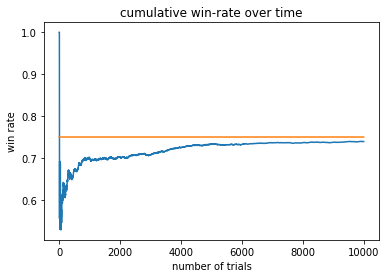

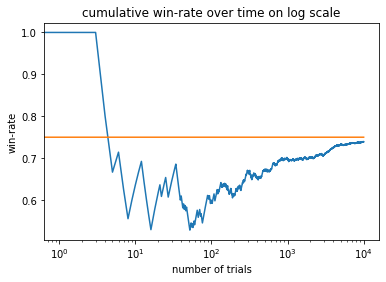

bandit1 estimate win rate: 0.0 | true win rate: 0
bandit2 estimate win rate: 0.242 | true win rate: 0.25
bandit3 estimate win rate: 0.525 | true win rate: 0.5
bandit4 estimate win rate: 0.75 | true win rate: 0.75
total reward earned: 7393.0
overall win rate: 0.7393
num times selected each bandit: [30, 62, 259, 9653]


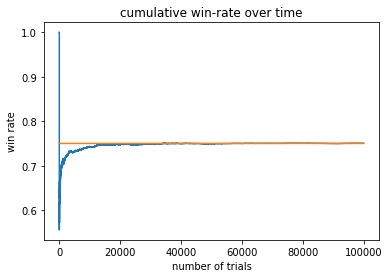

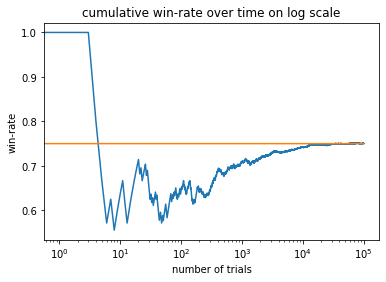

bandit1 estimate win rate: 0.0 | true win rate: 0
bandit2 estimate win rate: 0.238 | true win rate: 0.25
bandit3 estimate win rate: 0.497 | true win rate: 0.5
bandit4 estimate win rate: 0.752 | true win rate: 0.75
total reward earned: 75051.0
overall win rate: 0.75051
num times selected each bandit: [40, 84, 316, 99564]


In [ ]:
# importing essential libraries for graphing and array processing
import numpy as np
import matplotlib.pyplot as plt

# creating the blueprint for a bandit slot machine
class Bandit:
  def __init__(self, p):
    self.p = p # the winning rate
    self.p_hat = 0 # sample proportion, or the estimation for the winning rate, intialized to 0
    self.n = 0 # number of samples collected on this bandit, initialized to 0

  # draw the virtual bandit with a random probability p and check if won according to the winning rate
  def pull(self):
    # return 1 if won, 0 if lost
    return np.random.random() < self.p

  def update(self, x):
    # increment numbers of samples collected
    self.n += 1
    # calculate the new p hat from the previous p hat and the newly obtained value (0 or 1)
    self.p_hat = ((self.n - 1) * self.p_hat + x) / self.n

# return the upper bound of bandit
def ucb(X, N, n):
  """
  args
    X: sample proportion estimate of this bandit's win-rate
    N: total numbers of trials so far
    n: total numbers of time this bandit has been selected
  """
  return X + np.sqrt(2 * np.log(N) / n)

# run a simulation of multi-armed bandit problem with ucb
def run_simulation(bandits_probs_list, epsilon, trials):
  """
  args
    bandits_probs_list: a list containing the win-rates of bandits that we want to create
    epsilon: greedy exploration rate
    trials: numbers of trials, times we pull from bandits
  """
  # create a list of bandit objects according to their probabilities of win rate
  bandits = [Bandit(p) for p in bandits_probs_list]
  # initialize variables
  rewards = np.zeros(trials)
  N = 0

  # beginning by playing each bandit once to avoid 0/0
  for bandit in bandits:
    x = bandit.pull()
    bandit.update(x)
    N += 1
  
  # repeat for "trials" times
  for i in range(trials):
    # get the index of the bandit with the highest upper confidence bound
    bandit_index = np.argmax([ucb(bandit.p_hat, N, bandit.n) for bandit in bandits])
    # pull the bandit and update the sample proportion according to its reward, increment trials taken
    x = bandits[bandit_index].pull()
    bandits[bandit_index].update(x)
    N += 1
    # logging the reward for trial i
    rewards[i] = x

  # plot the results on linear scale
  cumulative_rewards = np.cumsum(rewards)
  win_rates = cumulative_rewards / (np.arange(trials) + 1)
  plt.plot(win_rates)
  plt.plot(np.ones(trials) * np.max(bandits_probs_list))
  plt.title('cumulative win-rate over time')
  plt.xlabel('number of trials')
  plt.ylabel('win rate')
  plt.show()
  # plot the results on log scale
  cumulative_rewards = np.cumsum(rewards)
  win_rates = cumulative_rewards / (np.arange(trials) + 1)
  plt.plot(win_rates)
  plt.plot(np.ones(trials) * np.max(bandits_probs_list))
  plt.xscale('log')
  plt.title('cumulative win-rate over time on log scale')
  plt.xlabel('number of trials')
  plt.ylabel('win-rate')
  plt.show()

  # print proportion estimates for each bandit
  for i, bandit in enumerate(bandits):
    print(f'bandit{i + 1} estimate win rate: {round(bandit.p_hat, 3)} | true win rate: {bandit.p}')
  print("total reward earned:", rewards.sum())
  print("overall win rate:", rewards.sum() / trials)
  print("num times selected each bandit:", [bandit.n for bandit in bandits])

if __name__ == '__main__':
  # simulate two multi-armed bandit problem with 4 machines with win-rates 0, 0.25, 0.5, 0.75
  # epsilon default to 0.1, thus 10% of random selection chance
  # N defaulted to 10000 trials for first simulation, 100000 for the second
  run_simulation([0, 0.25, 0.5, 0.75], 0.1, 10000)
  run_simulation([0, 0.25, 0.5, 0.75], 0.1, 100000)

**IV. Reflection**
- Compared to Epsilon Greedy, we see the agent's overall win-rate on UCB approaches quickly to the actual win rate on the optimal bandit, representing that the agent consolidating its selection choice down to the optimal bandit as it becomes more confident of its sample proportion estimate. By numbers (num times selected each bandit), we also see that there is also more times exploiting the optimal machine
  - This makes UCB definitely superior when performing on higher numbers of trials

## 3. Markov Decision Processes (MDP)
- As preluded in the introduction, the diagram with circular interaction between the agent and its environment essentially is a simplified version of MDP
- MDP is a fundamental framework from which many of the advanced RL algorithms are developed from

![alt text](https://www.researchgate.net/profile/Daniele_Grattarola/publication/323218981/figure/fig9/AS:594583624896516@1518771191892/Graph-representation-of-an-MDP-Each-gray-node-represents-a-state-each-arc-leaving-a.png)

image source: [Graph representation of an MDP by Daniele Grattarola](https://www.researchgate.net/figure/Graph-representation-of-an-MDP-Each-gray-node-represents-a-state-each-arc-leaving-a_fig9_323218981)
  - Basically, it models the probabilisitc transitions between states through choosing certain actions and afterwards the rewards that will be obtained
    - ${S}$: state
    - ${a}$: action
    - the 0-1 decimals mark the probabilities
    - the signed integers mark the rewards

- MDP is derived upon basic Markov Models and a concept known as Markov Assumption (Markov Property)
    - We will be assuming that the probability distribution of our next states and rewards depends solely on our current state, therefore the first-order Markov assumption
      - though this may seem restriciting and unrealistic at first, the Markov Assumption is crucial towards simplifying the complex probablisitic transitions we observe in real life, and it is shown to be extremely practical and applicable in many fields

- Important Terminologies
  - Episode
    - each round of the game from a "start state" to a "terminal state"
  - Policy - ${\pi(s)}$
    - a function that decides what action to commit given a state $s$
    - the "brain" of the agent
    - this is essentially what we want to optimize
  - State Value Function - ${V_\pi(s)}$
    - this outputs the expected future return, or the expected cumulative
future rewards, that is, the estimate of the summation of all rewards that will be received after state $s$ if we stick to using our current policy ${\pi}$
    - general iterative formula
    ![alt text](https://i.imgur.com/uIsblET.png)
      - ${E_\pi}$(): expected value of
      - ${R(t+1)}$: reward of next step after current state ${s}$
      - ${\gamma}$: discounting rate
        - weighting more the expected returns of the near future states by downgrading the expected value of reward the farther a future state is
        - think that we are less confident about the expected returns the farther its state is from our current state
      - ${V_\pi(s')}$: state value of next state
  - Action Value Function - ${Q_\pi(s, a)}$ 
    - this outputs the expected future return given we commit an action ${a}$ on state ${s}$ and thereafter stick to using our current policy ${\pi}$
    - general iterative formula 
    ![alt text](https://i.imgur.com/NVIC3Zo.png)
      - ${R(t+1)}$: reward of next step by choosing action $a$ on current state $s$
      - ${\gamma}$: discounting rate
      - ${\sum_{a'}\ \pi(a' | s')\ Q_\pi(s', a') | S_t = s, A_t = a}$: the expected action value of the next state given that we choose action $a$ on our state $s$ by multiplying together the probability and value pair of each of possible next action ${a'}$ in the next state ${s'}$

- Solving MDP
  - the solving procedures for MDP taken by many algorithms are often iterative and involve a loop between two steps
    - policy evaluation
      - this step will solve for the state value function or action value function discussed above given the agent's current policy
    - policy improvement (control)
      - this step will update our policy by selecting the action with the highest action value at each state
        - thus needing action value function

- For potential concerns
  - don't worry if the theories don't make much sense now, once we get into more specific algorithms and later the code sections everything will be clearer!
  - if you really want to understand the math behind all this, here are some additional outside resources to further your understanding

- Additional readings for MDP
  - [Reinforcement Learning Demystified: Markov Decision Processes (Part 1)](https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-1-bf00dda41690)
  - [Reinforcement Learning Demystified: Markov Decision Processes (Part 2)](https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-2-b209e8617c5a)
  - [Barto Sutton Reinforcement Learning](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf): Chapter 3, Page 47


## 4. Monte Carlo Method
**I. Intro & Background**

Monte Carlo is an effective algorithm that, similar to solving a traditional multi-armed bandit problem, collect empirical data (states, actions, and rewards) by repeatedly playing the game and uses the samples returns to gradually update, refine its policy, thus improving the agent's decision making
  - we can essentially think that Monte Carlo treats the action selection at each state as a separate multi-armed bandit problem, only that in this case the bandits are interrelated and we are trying to optimize them all at once 

**II. Monte Carlo on MDP Intuition**
- policy evaluation
  - solving policy evaluation involves finding the state value functions ${V(s)}$ for all states given a policy
  - MC does this by running many rounds of episodes, and for each episode record each state the agent has been through and their corresponding reward, then calculating and recording the returns $G$ for each state in reverse time steps using iterative formula: ${G(t) = R(t+1) + \gamma\ G(t+1)}$, at last averaging G out for each state to obtain the mean return, the state values we wanted
- policy improvement (control)
  - recall that the action value function ${Q(s, a)}$ is required for solving policy control problem
  - similar to the approach we took in policy evluation, MC finds ${Q(s, a)}$ by logging an addition variable action ${a}$ the agent took on top of state ${s}$ and reward ${r}$ as it runs through many episodes
    - after obtaining the action value function, we can then update the agent's policy by simply choosing the action that returns the highest action value at each state: $\pi(s) = argmax_aQ(s,a)$

- additional readings for Monte Carlo
  - [Barto Sutton Reinforcement Learning](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf): Chapter 5, Page 91


**III. Code in FrozenLake Environment**

<img src="https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2018/03/Frozen-Lake.png" alt="alt text"  width='300' height='300'>

- FrozenLake is one of the open-source training environments created by OpenAI for reinforcement learning experiments
  - it is a gridworld-like game with a movable agent and four states on the map: 
    - $S$ for the starting state, where the agent begins our game
    - $F$ for frozen lake, where the agent can travel through
    - $H$ for hole, a terminal state with reward of 0, where the agent tries to avoid
    - $G$ for the goal state, a terminal state with reward of 1, where the agent tries to go
    - again, agent will only receive a reward of 1 if it reaches the goal state, receiving 0 otherwise
  - we want to train the agent to navigate through each map, reaching the goal state through frozen lake without walking into a hole.
- We will be using this environment to test out our codes for Monte Carlo and later TD(0) and Q-Learning
  - [Website](https://gym.openai.com/envs/FrozenLake-v0/)
  - [Source Code](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py)

In [ ]:
# importing OpenAI gym containing the FrozenLake environment we will use
import gym
# importing essential library for array processing
import numpy as np

# map a dictionary corresponding numbers to understandable actions for debugging uses
actions = {
    0 : 'Left',
    1 : 'Down',
    2 : 'Right',
    3 : 'Up'
}

# play through an episode of FrozenLake and return a list of (state, action, reward) observed using our current policy
def play_episode(env, policy, epsilon, i):
  """
  args
    env: environment
    policy: a dictionary storing states [keys] and the corresponding actions [values]
    epsilon: greedy exploration rate 
    i: the episode number we are on, for debugging purpose
  """
  # reset the environment to starting state
  env.reset()
  # initialize a list to store the returning triples: state, action, and reward
  states_actions_rewards = []
  # mark the start state
  state = 0

  # start our episode with a maximum of 100 steps available before automatic termination
  for t in range(100):
    # epsilon greedy policy for exploration, since by strictly following our policy we might end up not exploring some states at all
    # draw a random float from 0 to 1, and if it is less than our epsilon
    if np.random.uniform(0,1) < epsilon:
      # choose random action based on our environment's action space
      action = env.action_space.sample()
    else:
      # choose the action decided by our policy
      action = policy[state]
    # commit the action and get the returning new state, reward, boolean if we reached a terminal state, and debugging information
    next_state, reward, done, info = env.step(action)
    # append the return as a tuple to the list
    states_actions_rewards.append((state, action, reward))
    # check that if we reached a terminal state if so print out the how many steps it took, then break through the loop
    if done:
      print(f"Episode {i} finished after {t+1} timesteps")
      break
    # go to our next state
    state = next_state

  return states_actions_rewards

# a special "tiebreaking" argmax that would return a random index between indexes of equal maximums
# very crucial since regular argmax would favor index with lower numerical values if their corresponding values are equal maximums
  # in the beginning our game, we initialized the action values across our q-table to be all 0s
  # argmax then would only choose index 0, that is, in our context, the action of going left
  # since we can't go any further left when we are on the left boundary, choosing left regardless would bring us to the same state
  # the game therefore would result in a unending loop unless epsilon greedy luckily chooses random action that bring us out of it and break the initial 0 tie of q-table
def random_argmax(b):
  """
  args
    b: 1-dimensional array, a row of our q-table representing the action values of a single state
  """
  return np.random.choice(np.where(b == b.max())[0])

# train the agent on "episodes" amount of games in the environment with Monte Carlo, 
# return our trained policy, action values table, and dictionary storing cumulative reward/numbers of visits
def run_MC(env, initial_policy, episodes=25000, epsilon=0.2, gamma=0.95):
  """
  args
    env: environment
    initial_policy: a random initial dictionary storing states [keys] and corresponding actions [values]
  kwargs
    episodes: numbers of episodes we want to train our agent on, default to 25000
    epsilon: greedy rate for exploring, default to 0.2
    gamma: discounting rate for expected future return, default to 0.95
  """
  # initialize a two dimensional np array storing state-action values Q(s,a) with numbers of states by numbers of actions (in our case 16 by 4) (row by column)
  # commonly referred to as the q-table
    # note that we will be solving only for action value functions since it allows us to update our policy based the each action's value
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  # create a dictionary storing a list containing cumulative return AND the numbers of visits [values] for each state and action pair [key]
  returns_Q = dict()
  # set our policy to our passed-in initial policy
  policy = initial_policy

  # for each episode
  for i in range(episodes):
      # play and get the states_actions_rewards return
      episode = play_episode(env, policy, epsilon, i)
      # initialize the return of terminal state to be 0, by definition
      G = 0
      # loop through the states_actions_rewards triples in reverse order
      for state, action, reward in reversed(episode):
          # calculate the return
          G = gamma*G + reward 
          # if state and action pair exists in our dictionary
          if (state, action) in returns_Q:
            # increment the cumulative return and numbers of visit
            returns_Q[state, action][0] += G
            returns_Q[state, action][1] += 1
          else:
            # create state action key pair
            returns_Q[state, action] = [G, 1]
          # update the q-table by taking the average of returns (cumulative returns divided by numbers of visits)
          Q[state, action] = returns_Q[state, action][0] / returns_Q[state, action][1] 
          # update policy for the state by getting the index of the action with highest action value
          policy[state] = random_argmax(Q[state, :])
        
  # get our final policy
  for state in range(env.observation_space.n):
    policy[state] = random_argmax(Q[state, :])

  return policy, Q, returns_Q

if __name__ == '__main__':
  # create the FrozenLake environment with no slippery feature
  env = gym.make('FrozenLake-v0', is_slippery = False)
  # initialize a random policy (as a seed)
  initial_policy = {0:1, 1:2, 2:0, 3:1, 4:2, 5:1, 6:1, 7:1, 8:2, 9:0, 10:1, 11:3, 12:2, 13:2, 14:3}
  # train our agent on a 10000 episodes FrozenLake simulation using Monte Carlo with greedy and discounting rate of 0.2 and 0.95, respectively
  policy, Q, returns_Q = run_MC(env, initial_policy, episodes=10000, epsilon=0.2, gamma=0.95)
  print()
  print("Final Policy:")
  # print the action to take at each state according to our finalized policy
  for state in policy:
    print(f'{state}: Go {actions[policy[state]]}')
  print()
  # print the FrozenLake environment and their corresponding state numbers to do mental checkings
  print('0  1  2  3     S  F  F  F')
  print('4  5  6  7     F  H  F  H')
  print('8  9  10 11    F  F  F  H')
  print('12 13 14 15    H  F  F  G')

Streaming output truncated to the last 5000 lines.
Episode 5024 finished after 6 timesteps
Episode 5025 finished after 6 timesteps
Episode 5026 finished after 8 timesteps
Episode 5027 finished after 5 timesteps
Episode 5028 finished after 6 timesteps
Episode 5029 finished after 7 timesteps
Episode 5030 finished after 8 timesteps
Episode 5031 finished after 3 timesteps
Episode 5032 finished after 6 timesteps
Episode 5033 finished after 6 timesteps
Episode 5034 finished after 4 timesteps
Episode 5035 finished after 6 timesteps
Episode 5036 finished after 3 timesteps
Episode 5037 finished after 6 timesteps
Episode 5038 finished after 4 timesteps
Episode 5039 finished after 5 timesteps
Episode 5040 finished after 3 timesteps
Episode 5041 finished after 6 timesteps
Episode 5042 finished after 6 timesteps
Episode 5043 finished after 6 timesteps
Episode 5044 finished after 6 timesteps
Episode 5045 finished after 6 timesteps
Episode 5046 finished after 7 timesteps
Episode 5047 finished after 3

**IV. Reflection**
- By the end of 10000 episodes, if we follow the finalized policy from the starting state, we will be able to arrive at the goal state without falling into any holes
  - Note that the final policy sometimes diverges from the path it chooses due to randomization, but regardless they should all lead to a safe path to our goal state

- Problem/Disadvantage:
  - Monte Carlo needs to wait for the termination of each episode in order to calculate for the value functions to conduct its policy evluation and improvement given that it needs to reach the terminal state to record all the states_actions_rewards pairs in order to calculate in reverse the returns $G$ for each state and then averaging for expected return
  - this means that Monte Carlo isn't a true "online" algorithm in a way it can't update while playing through an episode
  - becomes problematic when an episode takes a long time to finish or that it never finishes
    - though fortunately for FrozenLake the episode runtime is miniscule

## 5. Temporal Difference (TD) Learning with Q-Learning
**I. Intro & Background**
- While TD also learns from experience by collecting empirical data, in contrast to Monte Carlo, it is an online algorithm which means it can calculate and update values even when playing through an episode
  - Therefore, while Monte Carlo needs to wait for an episode to finish in order to update, TD can update at each step of the episode
- TD uses rewards as estimates for the value functions instead of needing to calculate the actual returns $G$
  - fundamentally, it can iteratively improve its estimates based on existing estimates, a process known as bootstrapping

**II. TD(0) & Q-Learning Intuition**
- policy evaluation
  - TD(0) is an algorithm in TD learning that calculates for the expected return ${V_\pi(s)}$
    - instead of using the average of the all actual returns like Monte Carlo in the calculation, TD(0) calculates for the average recursively using an alternative form of ${V(s)}$ $= V(s) + \alpha[r + \gamma V(s')-V(s)]$ by using an estimate expected return from the next state
      - $\alpha$: the learning rate, or the moving average, essentially controls how we weigh our new sample and old estimate to contribute to our new estimate
        - 0.0 means ignoring new sample and stick to old estimate, 1.0 means only consider new sample and ignore old estimate
      - now, instead of waiting for an entire episode to finish, we only need to wait for the next state to get $V(s')$ in order to update our $V$ for our current state

- policy control
  - Q-Learning is an algorithm used for solving action value functions for TD learning
  - It follows the same pattern as TD(0) in which we will only need to know the estimate of action value function of next state in order to update our estimate of the action value function of our current state, following: $Q(s,a) = Q(s,a) + \alpha[r + \gamma max_a'Q(s', a') - Q(s, a)]$
    - the inner term ${\gamma max_{a'}Q(s', a')}$ gives the discounted maximum action value we can receive in our next state
    - we are essentially looking ahead and evaluating the action value for choosing action $a$ on current state $s$ based on both its own reward and the maximum future action value we are expected to receive
  - It is also known as an off-policy method as the algorithm does not always follows the current best policy, rather choose random actions at times
    - though it tends to make episodes longer due to choosing suboptimal actions, it also explores more possible states, sometimes hideous ones, as a result
      - we will see that we are going to implement epsilon greedy for this, though so did we for MC for the same reason

- additional readings for Temporal Difference Learning and Q-Learning
  - [Barto Sutton Reinforcement Learning](https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf): Chapter 6, Page 119

**III. Code in FrozenLake Environment**

In [ ]:
# importing OpenAI gym containing the FrozenLake environment we will use
import gym
# importing essential library for array processing
import numpy as np

# map a dictionary corresponding numbers to understandable actions for debugging uses
actions = {
    0 : 'Left',
    1 : 'Down',
    2 : 'Right',
    3 : 'Up'
}

# tie breaking argmax, detailed explaination see MC code
def random_argmax(b):
  """
  args
    b: 1-dimensional array, a row of our q-table representing the action values of a single state
  """
  return np.random.choice(np.where(b == b.max())[0])

# train the agent on "episodes" amount of games in the environment with Q-Learning
def run_Q_Learning(env, initial_policy, episodes=25000, alpha=0.5, epsilon=0.2, gamma=0.95):
    """
    args:
        env: given environment
        initial_policy: a chosen random policy given to the agent at the start
    kwargs:
        episodes: number of episodes used for training
        alpha: learning rate for Q-learning
        epsilon: exploration rate 
        gamma: discount rate
    """
    # initialize a np array, also known as the q-table, storing state-action values Q(s,a) with size of states by size actions (in our case 16 by 4)
    Q = np.zeros((env.observation_space.n,env.action_space.n))
    # set our policy to initial policy
    policy = initial_policy

    for i in range(episodes):
      # reset the environment and mark the start state
      env.reset()
      state = 0
      for t in range(100):
        # epsilon greedy policy
        # draw a random float from 0 to 1, and if it is less than our epsilon
        if np.random.uniform(0,1) < epsilon:
          # choose random action based on our environment's action space
          action = env.action_space.sample()
        else:
          # choose the action decided by our policy
          action = policy[state]
        # commit the action and get the returning new state, reward, boolean if we reached a terminal state, and debugging information
        next_state, reward, done, info = env.step(action)
        # update our q-table immediately after a step using Q-Learning (off-policy TD control) algorithm
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
        # check that if we reached a terminal state if so print out the how many steps it took, then break through the loop
        if done:
          print(f"Episode {i} finished after {t+1} timesteps")
          break
        # update our policy according to actions with the highest action values with tie-breaking argmax
        policy[state] = random_argmax(Q[state, :])
        # go to our next state
        state = next_state
        
    # get our final policy
    for state in range(env.observation_space.n):
      policy[state] = random_argmax(Q[state, :])

    return policy, Q

if __name__ == '__main__':
  # create the FrozenLake environment with no slippery feature
  env = gym.make('FrozenLake-v0', is_slippery = False)
  # initialize a random policy
  initial_policy = {0:2, 1:3, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:2, 9:0, 10:1, 11:2, 12:3, 13:2, 14:1}
  # train our agent using Q-Learning on a 10000 episodes FrozenLake simulation with learning rate of 0.5, exploration rate of 0.2, and discounting rate of 0.95
  policy, Q = run_Q_Learning(env, initial_policy, episodes=10000, alpha=0.5, epsilon=0.2, gamma=0.95)
  print()
  print("Final Policy:")
  # print the action to take at each state according to our finalized policy
  for state in policy:
    print(f'{state}: Go {actions[policy[state]]}')
  print()
  # print the FrozenLake environment and their corresponding state numbers to do mental checkings
  print('0  1  2  3     S  F  F  F')
  print('4  5  6  7     F  H  F  H')
  print('8  9  10 11    F  F  F  H')
  print('12 13 14 15    H  F  F  G')

Streaming output truncated to the last 5000 lines.
Episode 5024 finished after 6 timesteps
Episode 5025 finished after 6 timesteps
Episode 5026 finished after 7 timesteps
Episode 5027 finished after 5 timesteps
Episode 5028 finished after 3 timesteps
Episode 5029 finished after 8 timesteps
Episode 5030 finished after 6 timesteps
Episode 5031 finished after 6 timesteps
Episode 5032 finished after 4 timesteps
Episode 5033 finished after 6 timesteps
Episode 5034 finished after 6 timesteps
Episode 5035 finished after 6 timesteps
Episode 5036 finished after 4 timesteps
Episode 5037 finished after 5 timesteps
Episode 5038 finished after 4 timesteps
Episode 5039 finished after 4 timesteps
Episode 5040 finished after 6 timesteps
Episode 5041 finished after 9 timesteps
Episode 5042 finished after 6 timesteps
Episode 5043 finished after 5 timesteps
Episode 5044 finished after 7 timesteps
Episode 5045 finished after 7 timesteps
Episode 5046 finished after 4 timesteps
Episode 5047 finished after 9

**IV. Reflection**
- Like MC, after 10000 episodes of training, we should obtain a final policy that would help the agent to safely walk through the FrozenLake
- One major difference, though, is we see that we can update our q-table immediately after taking an action instead of using the play_episode function in MC to have an entire episode finished before the calculation.
  - Still, the power of Q-Learning is not demonstrated fully since each episode in FrozenLake, as we discussed, takes miniscule time to finish, but for games with much longer episode runtime, Q-Learning will function superiorly

## 6. Conclusion/Reflection
- in the tutorial, we went over Reinforcement Learning at a glance. Following it, we looked into the classic problem of multi-armed bandits to study the explore-exploit tradeoff and saw applied algorithms of epsilon greedy and upper confidence bound in action, in code. We next looked at the markov decision processes framework that provides the foundation for more advanced algorithms. Then, we delved deeper into Monte Carlo and Temporal-Difference(TD) Learning with Q-Learning and at last implemented them both to train our agent to navigate safely in the FrozenLake environment
- ultimately, while we did cover many of the fundamental theories and algorithms, they are only snippets in the grand field of Reinforcement Learning. There is so much to learn and understand about RL, math-wise and code-wise, topics like Approximation Methods, Deep Reinforcement Learnig with neural networks. At the same time, RL has so much more potentials than to solve a simple gridworld-like environment, as we saw in the intro section's applications
- at the end, I want to thank you for following through this tutorial. It is my first tutorial ever created, so it's kind of special. I really hope you learned and took away something from it.

#Good Luck on your RL journey!
—— Xiaocong Yan


## Work Referenced:
- Mohammad Ashraf. 2018. Reinforcement Learning Demystified: Markov Decision Processes (Part 1). Medium. Retrieved 20 July 2020, from https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-1-bf00dda41690
- Mohammad Ashraf. 2018. Reinforcement Learning Demystified: Markov Decision Processes (Part 2). Medium. Retrieved 20 July 2020, from https://towardsdatascience.com/reinforcement-learning-demystified-markov-decision-processes-part-2-b209e8617c5a
- Richard S. Sutton and Andrew G. Barto. 2018. Reinforcement Learning: An Introduction. A Bradford Book, Cambridge, MA, USA. Retrieved 20 July 2020, from http://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf
- Conor McDonald. Solving multiarmed bandits: A comparison of epsilon-greedy and Thompson sampling. (2018). Medium. Retrieved 20 July 2020, from https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50